## Download GWTC-1 data

In [1]:
!wget https://dcc.ligo.org/public/0157/P1800370/002/GWTC-1_sample_release.tar.gz

--2020-08-12 22:14:47--  https://dcc.ligo.org/public/0157/P1800370/002/GWTC-1_sample_release.tar.gz
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89895447 (86M) [application/x-gzip]
Saving to: ‘GWTC-1_sample_release.tar.gz’

GWTC-1_sample_relea 100%[===================>]  85.73M   109KB/s    in 15m 21s 

2020-08-12 22:30:11 (95.3 KB/s) - ‘GWTC-1_sample_release.tar.gz’ saved [89895447/89895447]



In [1]:
!tar -xvzf GWTC-1_sample_release.tar.gz

./GWTC-1_sample_release/
./GWTC-1_sample_release/GW170729_GWTC-1.hdf5
./GWTC-1_sample_release/GW151226_GWTC-1.hdf5
./GWTC-1_sample_release/GW170809_GWTC-1.hdf5
./GWTC-1_sample_release/GW170104_GWTC-1.hdf5
./GWTC-1_sample_release/GW170817_GWTC-1.hdf5
./GWTC-1_sample_release/GW170608_GWTC-1.hdf5
./GWTC-1_sample_release/GW170814_GWTC-1.hdf5
./GWTC-1_sample_release/GW151012_GWTC-1.hdf5
./GWTC-1_sample_release/GW170809_priorChoices_GWTC-1.hdf5
./GWTC-1_sample_release/GW170818_GWTC-1.hdf5
./GWTC-1_sample_release/GW150914_GWTC-1.hdf5
./GWTC-1_sample_release/GW170823_GWTC-1.hdf5


## Imports

In [1]:
import bilby
import gwpopulation as gwpop
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd

from astropy import cosmology, units
from scipy.interpolate import interp1d

from bilby.core.prior import Uniform, LogUniform, PriorDict
from gwpopulation.models import mass, spin

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Viewing the contents of the files

- The Default model uses this waveform: `IMRPhenomPv2` - Inspiral-Merger-Ringdown Phenomena v2 
- `SEOBNRv3` - Spin-Aligned Effective One Body Numerical Relativity
- The Gaussian model uses this waveform: `Overall` which combines the above two models

In [2]:
f = h5py.File('GWTC-1_sample_release/GW150914_GWTC-1.hdf5', 'r')
f.keys()

<KeysViewHDF5 ['IMRPhenomPv2_posterior', 'Overall_posterior', 'SEOBNRv3_posterior', 'prior']>

In [3]:
df1 = pd.DataFrame(np.array(f['IMRPhenomPv2_posterior']))
df1.keys()

Index(['costheta_jn', 'luminosity_distance_Mpc', 'right_ascension',
       'declination', 'm1_detector_frame_Msun', 'm2_detector_frame_Msun',
       'spin1', 'spin2', 'costilt1', 'costilt2'],
      dtype='object')

### Changing the names of some of the parameters to make them work with gwpopulation

We do this for `IMRPhenomPv2_posterior` first.

In [4]:
parameter_translator = dict(
    mass_1_det = 'm1_detector_frame_Msun',
    mass_2_det = 'm2_detector_frame_Msun',
    luminosity_distance = 'luminosity_distance_Mpc',
    a_1 = 'spin1',
    a_2 = 'spin2',
    cos_tilt_1 = 'costilt1',
    cos_tilt_2 = 'costilt2')

In [5]:
posteriors = list()
priors = list()

file = 'GWTC-1_sample_release/GW{}_GWTC-1.hdf5'

events = ['150914', '151012', '151226', '170104', '170608', '170729', '170809', '170814', 
          '170818', '170823']

for event in events:
    _posterior = pd.DataFrame()
    _prior = pd.DataFrame()
    with h5py.File(file.format(event), 'r') as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff['IMRPhenomPv2_posterior'][gwtc_key]
            _prior[my_key] = ff['prior'][gwtc_key]
    posteriors.append(_posterior)
    priors.append(_prior)

In [6]:
posteriors[0]

,mass_1_det,mass_2_det,luminosity_distance,a_1,a_2,cos_tilt_1,cos_tilt_2
0,43.561878,30.006974,360.963036,0.481479,0.551643,0.012162,0.137818
1,37.006684,35.723611,538.067256,0.323226,0.225597,0.454174,-0.482123
2,35.747480,34.267309,378.730720,0.490409,0.229346,-0.069300,-0.493216
3,45.168491,26.692544,446.937909,0.907815,0.128135,-0.127557,-0.694896
4,36.308165,35.889917,496.628291,0.144858,0.437158,0.487946,-0.237507
...,...,...,...,...,...,...,...
40831,38.577778,31.417375,503.472940,0.268453,0.194847,0.039890,-0.925528
40832,37.253314,33.156328,478.421089,0.805262,0.823590,0.655502,-0.985068
40833,40.528821,30.134671,516.916074,0.437801,0.408049,-0.277677,-0.280263
40834,35.683458,34.021918,464.564783,0.214438,0.819591,-0.557688,-0.119711


### Some Important Definitions

- Individual masses = mi; Individual spins = Si
- Total Mass = m1 + m2
- Mass ratio (q) = m2/m1, where m1 ≥ m2.
- Effective spin which is a combination of the spin components along the orbital angular momentum direction Lˆ, χeff = (S1/m1 + S2/m2)* Lˆ/M
- We will also characterize BH spins using the dimensionless spin variables χi = Si/m2i

Due to the expansion of spacetime as the gravitational wave is propagating, the frequencies measured by the instrument are redshifted relative to those emitted at the source (Thorne 1983). We capture these effects by distinguishing between masses as they would be measured in the source frame, denoted as above, and the redshifted masses, (1+z)mi, which are measured in the detector frame. 

- Hence m(source) = mass_det / (1+z)

Meanwhile, the amplitude of the wave scales inversely with the luminosity distance (Misner et al. 1973). We use the GW measurement of the luminosity distance to obtain the cosmological redshift and therefore convert between detector-frame and source-frame masses. We assume a fixed Planck 2015 (Planck Collaboration et al. 2016) cosmology throughout to con- vert between a source’s luminosity distance and its redshift (Hogg 1999).

To do this, first create a function that takes in luminosity distance and gives back redshift. Here that function is `dl_to_z`.

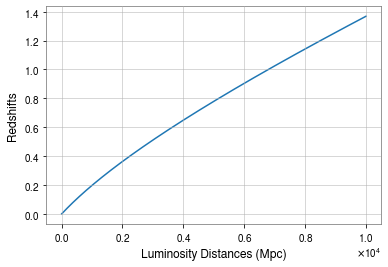

In [7]:
luminosity_distances = np.linspace(1, 10000, 1000)
redshifts = np.array([cosmology.z_at_value(cosmology.Planck15.luminosity_distance, 
                                                   dl * units.Mpc) for dl in luminosity_distances])
dl_to_z = interp1d(luminosity_distances, redshifts)

plt.plot(luminosity_distances, redshifts)
plt.xlabel('Luminosity Distances (Mpc)')
plt.ylabel('Redshifts')
plt.show()

In [8]:
for posterior in posteriors:
    posterior['redshift'] = dl_to_z(posterior['luminosity_distance'])
    posterior['mass_1'] = posterior['mass_1_det'] / (1 + posterior['redshift'])
    posterior['mass_2'] = posterior['mass_2_det'] / (1 + posterior['redshift'])
    posterior['mass_ratio'] = posterior['mass_2'] / posterior['mass_1']

In [9]:
posteriors[0]

,mass_1_det,mass_2_det,luminosity_distance,a_1,a_2,cos_tilt_1,cos_tilt_2,redshift,mass_1,mass_2,mass_ratio
0,43.561878,30.006974,360.963036,0.481479,0.551643,0.012162,0.137818,0.077120,40.442921,27.858525,0.688836
1,37.006684,35.723611,538.067256,0.323226,0.225597,0.454174,-0.482123,0.112285,33.270867,32.117319,0.965329
2,35.747480,34.267309,378.730720,0.490409,0.229346,-0.069300,-0.493216,0.080717,33.077567,31.707947,0.958594
3,45.168491,26.692544,446.937909,0.907815,0.128135,-0.127557,-0.694896,0.094378,41.273212,24.390609,0.590955
4,36.308165,35.889917,496.628291,0.144858,0.437158,0.487946,-0.237507,0.104189,32.882193,32.503410,0.988481
...,...,...,...,...,...,...,...,...,...,...,...
40831,38.577778,31.417375,503.472940,0.268453,0.194847,0.039890,-0.925528,0.105532,34.895216,28.418332,0.814390
40832,37.253314,33.156328,478.421089,0.805262,0.823590,0.655502,-0.985068,0.100608,33.847949,30.125472,0.890024
40833,40.528821,30.134671,516.916074,0.437801,0.408049,-0.277677,-0.280263,0.108162,36.572999,27.193371,0.743537
40834,35.683458,34.021918,464.564783,0.214438,0.819591,-0.557688,-0.119711,0.097872,32.502395,30.988976,0.953437


## Specify the Model

#### Model A - Default (Model C as shown in the table below) 

Model for mass distribution: Talbot and Thrane 2018

- gwpop.models.mass.SinglePeakSmoothedMassDistribution()

Beta Distribution described by the model:

- gwpop.models.spin.independent_spin_magnitude_beta

Spin orientation represented by Talbot and Thrane 2017:

- gwpop.models.spin.independent_spin_orientation_gaussian_isotropic


Priors:
We adopt a prior on the spin magnitude model parameters which are uniform over the values of E[a] and Var[a] which satisfy αa, βa ≥ 1, avoiding numerically challenging singular spin distributions. To describe the spin orientation, we assume that the tilt angles between each black hole spin and the orbital angular momentum, ti, are drawn from a mixture of two distributions: an isotropic component, and a preferentially aligned component, represented by a truncated Gaussian distribution in costi peaked at costi = 1

In [10]:
modelA = bilby.hyper.model.Model([mass.SmoothedMassDistribution(),
                                  spin.independent_spin_magnitude_beta, 
                                  spin.independent_spin_orientation_gaussian_isotropic])

### Following is a snippet of prior models and prior ranges. The default model is Model C.

<img src="ModelParameters.png">

<img src="SpinParametersA.png">

<font color='green'>Just confirming, the values of alpha and beta are already constrained to be greater than 1 right (by the boundary conditions of other parameters)?</font>

<font color='green'>
    <h3>Am I doing something wrong with the prior? </h3> 
    <br>
    I need to know why I get a keyerror with alpha_chi_1 while running the sampler.
</font>

Will something like this help?

~~~
priors = bilby.prior.PriorDict(dict(
    x=bilby.prior.Uniform(0, 1, 'x'),
    y=bilby.prior.Cosine('y'),
    ratio=bilby.prior.Constraint(minimum=0, maximum=1, name='ratio')),
    conversion_function=conv)
~~~

<font color='green'>What is the right way to use gwpopulation.conversions in this case when we are dealing with mean and variance of beta distribution?</font>

In [17]:
priorsA = PriorDict()

# rate
priorsA['rate'] = LogUniform(minimum=1e-20, maximum=1e20, latex_label='$R$')

# mass
priorsA['alpha'] = Uniform(minimum=-4, maximum=12, latex_label='$\\alpha$')
priorsA['beta'] = Uniform(minimum=-4, maximum=12, latex_label='$\\beta$')
priorsA['mmin'] = Uniform(minimum=5, maximum=10, latex_label='$m_{\\min}$')
priorsA['mmax'] = Uniform(minimum=30, maximum=100, latex_label='$m_{\\max}$')
priorsA['lam'] = Uniform(minimum=0, maximum=1, latex_label='$\\lambda_{m}$')
priorsA['mpp'] = Uniform(minimum=20, maximum=50, latex_label='$\\mu_{m}$')
priorsA['sigpp'] = Uniform(minimum=0, maximum=10, latex_label='$\\sigma_{m}$')
priorsA['delta_m'] = Uniform(minimum=0, maximum=10, latex_label='$\\sigma_{m}$')

# spin magnitude
priorsA['amax'] = 1
priorsA['mu_chi'] = Uniform(minimum=0, maximum=1, latex_label='$\\mu_{\\chi}$')
priorsA['sigma_chi'] = Uniform(minimum=0, maximum=0.25, latex_label='$\\sigma_{\\chi}_1$')

# spin orientation
priorsA['xi_spin'] = Uniform(minimum=0, maximum=1, latex_label='$\\xi$')
priorsA['sigma_1'] = Uniform(minimum=0, maximum=4, latex_label='$\\sigma{1}$')
priorsA['sigma_2'] = Uniform(minimum=0, maximum=4, latex_label='$\\sigma{2}$')

In [18]:
likelihoodA = gwpop.hyperpe.HyperparameterLikelihood(posteriors=posteriors, 
                                                     hyper_prior=modelA, 
        conversion_function = gwpop.conversions.convert_to_beta_parameters)

06:18 bilby WARNING : Cannot import cupy, falling back to numpy.
06:18 bilby INFO    : No prior values provided, defaulting to 1.


In [22]:
likelihoodA.parameters.update(priorsA.sample())
likelihoodA.log_likelihood_ratio()

resultA = bilby.run_sampler(likelihood = likelihoodA, priors = priorsA, sampler='dynesty', 
                            nlive=50, label='Default', outdir = 'Default')

# Model B - Gaussian

This paper uses `Overall_posterior`.

In [28]:
posteriorsB = list()

for event in events:
    _posterior = pd.DataFrame()
    _prior = pd.DataFrame()
    with h5py.File(file.format(event), 'r') as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff['Overall_posterior'][gwtc_key]
    posteriorsB.append(_posterior)

In [29]:
for posterior in posteriorsB:
    posterior['redshift'] = dl_to_z(posterior['luminosity_distance'])
    posterior['mass_1'] = posterior['mass_1_det'] / (1 + posterior['redshift'])
    posterior['mass_2'] = posterior['mass_2_det'] / (1 + posterior['redshift'])
    posterior['mass_ratio'] = posterior['mass_2'] / posterior['mass_1']

### Sampling effective spins from a truncated Gaussian

Effective spins are drawn from a simple truncated Gaussian.

<img src="chieff.png">


### Sampling $\chi_{eff}$

In [54]:
def chi_eff(a1, a2, m1, m2, cost1, cost2):
    chieff = (a1*m1*cost1 + a2*m2*cost2)/(m1+m2)
    return chi_eff

In [55]:
for posterior in posteriorsB:
    posterior['chi_eff'] = chi_eff(posterior['a_1'], posterior['a_2'], 
                                posterior['mass_1'], posterior['mass_2'], 
                                posterior['cos_tilt_1'], posterior['cos_tilt_2'])

In [56]:
chieff_prior = dict(mu_chieff = Uniform(minimum = -1, maximum = 1, latex_label = "$\\mu$"),
                    var_chieff = Uniform(minimum = 0, maximum = 1, latex_label = "$\\sigma^2$"))

In [57]:
from scipy.special import erf

In [65]:
def truncated_gaussian(dataset, mu, var):
    norm = (2/(np.pi*var))**0.5 * (erf((1-mu)/(2*var)**0.5) + erf((1+mu)/(2*var)**0.5))**(-1)
    prob = np.exp(-(dataset['chi_eff'] - mu)**2 / (2 * var))
    return norm*prob

In [66]:
likelihoodB = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriorsB,
                                                     hyper_prior=truncated_gaussian)

11:06 bilby WARNING : Cannot import cupy, falling back to numpy.
11:06 bilby INFO    : No prior values provided, defaulting to 1.


In [67]:
priorsB = PriorDict()

priorsB['mu'] = Uniform(minimum=1, maximum=2, latex_label='$\\mu$')
priorsB['var'] = LogUniform(minimum=1e-2, maximum=1, latex_label='$\\sigma^2$')

# rate
# priorsB['rate'] = LogUniform()

# mass
priorsB['mass_1'] = LogUniform(minimum = , maximum = , latex_label = "$mass_1$")
priorsB['mass_ratio'] = Uniform(minimum = , maximum = , latex_label = "$q$")
priorsB['lam'] = 2.7
priorsB['mmin'] = 5


In [69]:
# likelihoodB.parameters.update(priorsB.sample())
# # likelihoodB.log_likelihood_ratio()

# resultB = bilby.run_sampler(likelihood = likelihoodB, priors = priorsB, sampler='dynesty', nlive=100)

The posterior distribution for mean and variance is:

<img src="posterior_mu_var.png">

# Rough Work

A coalescing compact binary in a quasicircular orbit can be completely characterized by its intrinsic parameters, namely its individual masses mi and spins Si, and its seven extrinsic parameters: right ascension, declination, luminosity distance, coalescence time, and three Euler angles characterizing its orientation (e.g., inclination,
orbital phase, and polarization). In this work, we will also use the total mass M = m1 + m2 and mass ratio q
defined in the following way:

q = m2/m1, where m1 ≥ m2. (1)

We will also refer to two other commonly used mass parametrizations: 
the chirp mass Mc = (m1m2)
3/5/(m1 + m2)
1/5 and the symmetric mass ratio
η = m1m2/(m1 + m2)
2
With regard to spin, we define an effective spin [46–48], which is a combination of the spin components along the orbital angular momentum direction Lˆ, in the following way:

χeff = (S1/m1 + S2/m2) · Lˆ/M (2)

where S1 and S2 are the spins on the individual BH. We will also characterize BH spins using the dimensionless
spin variables

χi = Si/m2i. (3)

We will express these dimensionless spins in terms of Cartesian components χi,x, χi,y, χi,z, expressed relative
to a frame with ˆz = Lˆ and (for simplicity) at the orbital frequency corresponding to the earliest time of astrophysical interest (e.g., an orbital frequency of ' 10 Hz).

170817 not inculded in this analysis

In [11]:
# Since this file has different headers

f = h5py.File('GWTC-1_sample_release/GW170817_GWTC-1.hdf5', 'r')
f.keys()

<KeysViewHDF5 ['IMRPhenomPv2NRT_highSpin_posterior', 'IMRPhenomPv2NRT_highSpin_prior', 'IMRPhenomPv2NRT_lowSpin_posterior', 'IMRPhenomPv2NRT_lowSpin_prior']>

In [27]:
luminosity_prior = luminosity_distances ** 2

dz_ddl = np.gradient(redshifts, luminosity_distances)
plt.plot(dz_ddl)
plt.show()

redshift_prior = scipy.interpolate.interp1d(redshifts, luminosity_prior/(dz_ddl*(1 + redshifts)))